In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from IPython.display import Image

In [2]:
import cv2,os

data_path='CT'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) 

print(label_dict)
print(categories)
print(labels)

{'Covid': 0, 'Normal': 1}
['Covid', 'Normal']
[0, 1]


In [3]:
img_size=100,100,1
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        resized=image.load_img(img_path,color_mode="grayscale", target_size=(100,100))
        resized=image.img_to_array(resized)
        data.append(resized)
        target.append(label_dict[category])

In [7]:
img_path

'CT\\Normal\\997.png'

In [4]:
import numpy as np

data=np.array(data)/255.0
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
data.shape

(699, 100, 100, 1)

In [6]:
np.save('data_CT',data)
np.save('target_CT',new_target)

In [7]:
data=np.load('data_CT.npy')
target=np.load('target_CT.npy')

In [8]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:]
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,3,3]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(32, parrallel_kernels[k],activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 98, 98, 96)        960       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        55360     
_________________________________________________________________
activation (Activation)      (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0

In [15]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [33]:
checkpoint=ModelCheckpoint("CT_Covid_best_model_2.hdf5",monitor='accuracy',verbose=1,save_best_only=True,mode='max')

In [34]:
final=model.fit(train_data,train_target,epochs=20,steps_per_epoch=8,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 3.1265 - accuracy: 0.6060
Epoch 00001: accuracy improved from -inf to 0.60601, saving model to CT_Covid_best_model_2.hdf5
8/8 [==============================] - 17s 2s/step - loss: 3.1265 - accuracy: 0.6060 - val_loss: 0.6846 - val_accuracy: 0.5238
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5565
Epoch 00002: accuracy did not improve from 0.60601
8/8 [==============================] - 17s 2s/step - loss: 0.6872 - accuracy: 0.5565 - val_loss: 0.6824 - val_accuracy: 0.6825
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.6272
Epoch 00003: accuracy improved from 0.60601 to 0.62721, saving model to CT_Covid_best_model_2.hdf5
8/8 [==============================] - 17s 2s/step - loss: 0.6737 - accuracy: 0.6272 - val_loss: 0.6579 - val_accuracy: 0.5556
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.6184
Epoch

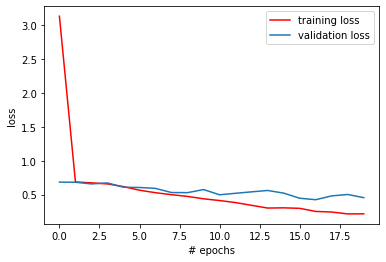

In [35]:
from matplotlib import pyplot as plt

plt.plot(final.history['loss'],'r',label='training loss')
plt.plot(final.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

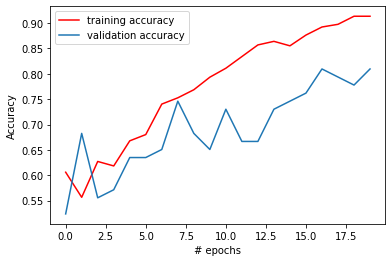

In [36]:
plt.plot(final.history['accuracy'],'r',label='training accuracy')
plt.plot(final.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
from tensorflow.keras.models import load_model

In [17]:
model=load_model("CT_Covid_best_model_2.hdf5")

In [18]:
import os
y_actual=[]
y_test=[]

In [19]:
for i in range(test_data.shape[0]):
    img=np.expand_dims(test_data[i],axis=0)
    p=model.predict_classes(img)
    y_test.append(p[0])
    y_actual.append(test_target[i,1])

In [20]:
y_test=np.array(y_test)
y_actual=np.array(y_actual)

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
cm=confusion_matrix(y_actual,y_test)

In [24]:
import seaborn as sns

<AxesSubplot:>

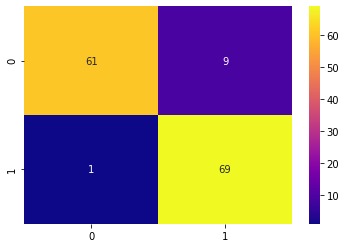

In [25]:
sns.heatmap(cm,cmap="plasma",annot=True)